## Data Visualization for DTLS and CID Performance

### Overview
This script is part of a Bachelor thesis project focusing on analyzing and visualizing DTLS handshake and CoAP message data. It processes current consumption data and packet metrics from CSV logs generated by Nordic PPK and pcap files. The goal is to generate plots that compare performance with Connection ID in DTLS 1.2 and 1.3.

### Key Functionalities
1. **Data Loading and Preprocessing:**
   - Extract relevant columns from the CSV files.
   - Normalize current measurements and convert GPIO data to match CoAP cycles.

2. **Cycle Grouping:**
   - Group CoAP cycles (`D0` signals) and DTLS handshakes (`D1` signals).

3. **Statistics Calculation:**
   - Compute metrics like start/end times, average/peak currents, and total charge for each group.

4. **Packet Analysis:**
   - Use pcap aquired with tcpdump to calculate bytes sent and received during CoAP and handshake events.

5. **Visualization:**
   - Generate bar plots and scatter plots to show total charge, peak current, and timing.

---
### Author Information
- **Author:** Johann Zürner
- **Date Created:** January 16, 2025
- **Purpose:** Part of a Bachelor thesis project at Hochschule Bonn-Rhein-Sieg (HBRS) analyzing DTLS and CoAP performance.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import numpy as np

In [2]:
all_ciphers = [
               "v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID_SECP256R1_CERT",
               "v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT",
               "v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID_X25519_CERT",               
               "v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT",
               "v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_SECP256R1_PSK",
               "v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK", 
               "v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_X25519_PSK",
               "v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_PSK"
               ]
remaining_ciphers = [
                    "v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_CID_SECP256R1_CERT",
                    "v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_CID_X25519_CERT",
                    "v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_CID_SECP256R1_PSK",
                    "v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_CID_X25519_PSK",
                    "v1_3_TLS_AES_128_GCM_SHA256_CID_SECP256R1_CERT",
                    "v1_3_TLS_AES_128_GCM_SHA256_CID_X25519_CERT",
                    "v1_3_TLS_AES_128_GCM_SHA256_CID_SECP256R1_PSK",
                    "v1_3_TLS_AES_128_GCM_SHA256_CID_X25519_PSK",
                     ]

In [3]:
columns = ["Timestamp(ms)", "Current(uA)", "D0", "D1"] # Extract only those columns
base_path = r"C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen"
filename = "v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK"

file_path = rf"{base_path}\ppk_csv\{filename}.csv"

version_code = "_".join(filename.split("_")[:2]) 
dtls_version = {"v1_2": "DTLS 1.2", "v1_3": "DTLS 1.3"}.get(version_code)
parts = filename.split("_")
cipher_suite_end_index = parts.index("noCID") if "noCID" in parts else parts.index("CID")
cipher_suite = "_".join(parts[2:cipher_suite_end_index])
curve = parts[-2]
auth_method = parts[-1]
pcap_file = rf"{base_path}\pcap\csv_exports\{filename}.csv"
pcap_df = pd.read_csv(pcap_file)
df = pd.read_csv(file_path, usecols=columns)
memory_log = rf"{base_path}\memory\{filename}.txt"

#pd.set_option("display.max_columns", None)
#pd.set_option("display.width", 1000)       
#pd.set_option("display.max_colwidth", None)  

df["Current(uA)"] = df["Current(uA)"] / 1000  # Convert µA to mA
df = df.rename(columns={"Current(uA)": "Current(mA)"}) # Rename column
df["D0"] = pd.to_numeric(df["D0"], errors="coerce").fillna(0).astype(int) # Converts values to numeric unless non-numeric then NaN (column contains also X as value)
df["D1"] = pd.to_numeric(df["D1"], errors="coerce").fillna(0).astype(int)  # Convert D1 to numeric 

C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\435206200.py:16: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=columns)


In [4]:
# Generate group numbers for D0 and D1
df["CoAP_Cycle"] = ((df["D0"] == 1) & (df["D0"].shift(fill_value=0) == 0)).cumsum() * (df["D0"] == 1)
df["Handshakes"] = ((df["D1"] == 1) & (df["D1"].shift(fill_value=0) == 0)).cumsum() * (df["D1"] == 1)

# Calculate statistics for D0
current_coap = df[df["D0"] == 1].groupby("CoAP_Cycle").agg(
    Start_Time=("Timestamp(ms)", "first"),
    End_Time=("Timestamp(ms)", "last"),
    Avg_Current=("Current(mA)", "mean"),
    Peak_Current=("Current(mA)", "max")
)

# Add derived columns for D0
current_coap["Time_Diff(s)"] = (current_coap["End_Time"] - current_coap["Start_Time"]) / 1000
current_coap["Total_Charge(mC)"] = current_coap["Avg_Current"] * current_coap["Time_Diff(s)"]

# Calculate statistics for D1
current_handshakes = df[df["D1"] == 1].groupby("Handshakes").agg(
    Start_Time=("Timestamp(ms)", "first"),
    End_Time=("Timestamp(ms)", "last"),
    Avg_Current=("Current(mA)", "mean"),
    Peak_Current=("Current(mA)", "max")
)

# Add derived columns for D1
current_handshakes["Time_Diff(s)"] = (current_handshakes["End_Time"] - current_handshakes["Start_Time"]) / 1000
current_handshakes["Total_Charge(mC)"] = current_handshakes["Avg_Current"] * current_handshakes["Time_Diff(s)"]

current_handshakes = current_handshakes.reset_index()
current_handshakes["Handshakes"] = current_handshakes["Handshakes"] - 1

# Reset index for D1 and rename the group column
#current_handshakes = current_handshakes.reset_index().rename(columns={"GPIO_high_D1": "Group_coap"})
current_coap=current_coap.round(2)
current_handshakes=current_handshakes.round(2)

current_coap["Bytes_Sent"] = 0
current_coap["Bytes_Received"] = 0

current_handshakes["Bytes_Sent"] = 0
current_handshakes["Bytes_Received"] = 0

In [5]:
if version_code == "v1_2":
# Process handshakes based on the DTLS version
    #print("Processing DTLS 1.2 Handshakes...")

    for group in current_handshakes["Handshakes"]:
        # Identify the start of the handshake (first "Client Hello")
        handshake_start = pcap_df[
            (pcap_df["Info"].str.contains("Client Hello"))
        ].index[0]

        # Identify the end of the handshake (second "Change Cipher Spec")
        handshake_end = pcap_df[
            (pcap_df["Info"].str.contains("Change Cipher Spec"))
        ].index[1]  # Directly select the second occurrence

        # Extract packets belonging to this handshake
        handshake_packets = pcap_df.loc[handshake_start:handshake_end]

        # Calculate Bytes Sent and Bytes Received
        bytes_sent = handshake_packets[handshake_packets["Source"].isin(["10.1.1.2", "10.1.1.3"])]["Length"].sum()
        bytes_received = handshake_packets[handshake_packets["Source"] == "10.1.1.10"]["Length"].sum()

        # Update current_handshakes DataFrame
        current_handshakes.loc[current_handshakes["Handshakes"] == group, "Bytes_Sent"] = bytes_sent
        current_handshakes.loc[current_handshakes["Handshakes"] == group, "Bytes_Received"] = bytes_received
        
previous_end_index = -1  # Start before the first index

for group in current_coap.index:  # Iterate over indices in current_coap
    #print(f"\nProcessing group {group}...")

    # Identify start (Application Data or Connection ID from 10.1.1.2 or 10.1.1.3)
    try:
        start_index = pcap_df[
            (pcap_df["Info"].str.contains("Application Data|Connection ID")) &
            ~(pcap_df["Info"].str.contains("Change Cipher Spec")) &
            (pcap_df["Source"].isin(["10.1.1.2", "10.1.1.3"])) &
            (pcap_df.index > previous_end_index)  # Ensure we only look after the previous end index
        ].index[0]
        #print(f"Start index (aligned with No field) for group {group}: {start_index + 1}")
    except IndexError:
        #print(f"No start packet found for group {group}.")
        continue

    # Identify end (next Application Data from 10.1.1.10 after the start index)
    try:
        end_index = pcap_df[
            (pcap_df["Info"].str.contains("Application Data")) &
            (pcap_df["Source"] == "10.1.1.10") &
            (pcap_df.index > start_index)  # Ensure we look after the start index
        ].index[0]
        #print(f"End index (aligned with No field) for group {group}: {end_index + 1}")
    except IndexError:
        print(f"No end packet found for group {group}.")
        continue

    # Update the previous end index to avoid overlaps in future iterations
    previous_end_index = end_index

    # Extract packets belonging to this CoAP group
    coap_packets = pcap_df.loc[start_index:end_index]
    #print(f"Packets for group {group} from No {start_index + 1} to No {end_index + 1}:")
    #print(coap_packets)

    # Calculate Bytes Sent and Received
    bytes_sent = coap_packets[coap_packets["Source"].isin(["10.1.1.2", "10.1.1.3"])]["Length"].sum()
    bytes_received = coap_packets[coap_packets["Source"] == "10.1.1.10"]["Length"].sum()

    #print(f"Bytes Sent for group {group}: {bytes_sent}")
    #print(f"Bytes Received for group {group}: {bytes_received}")

    # Update current_coap DataFrame
    current_coap.loc[group, "Bytes_Sent"] = bytes_sent
    current_coap.loc[group, "Bytes_Received"] = bytes_received

# Print the updated current_coap DataFrame
print("\nUpdated CoAP Data:")
#print(current_coap)
#print(current_handshakes)


Updated CoAP Data:


In [6]:
# Process DTLS 1.3 handshakes
if version_code == "v1_3":
    print("Processing DTLS 1.3 Handshakes...")

    # Identify all Client Hello messages
    client_hello_indices = pcap_df[(pcap_df["Info"].str.contains("Client Hello"))].index
    # Keep every other Client Hello
    filtered_client_hello_indices = client_hello_indices[::2]

    # Populate handshake_end_indices (first packet of length 71 or 72 after the start index)
    handshake_end_indices = []
    for start_index in filtered_client_hello_indices:
        end_index_candidates = pcap_df[
             ((pcap_df["Length"] >= 71) & (pcap_df["Length"] <= 74)) &
            (pcap_df.index > start_index)
        ].index

        # Append the first matching end index
        if not end_index_candidates.empty:
            handshake_end_indices.append(end_index_candidates[0])
    print("Filtered Client Hello Indices:", filtered_client_hello_indices.tolist())
    print("Handshake End Indices:", handshake_end_indices)

    # Ensure the lengths match
    if len(filtered_client_hello_indices) != len(handshake_end_indices):
        print("Error: Mismatch between start and end indices!")
        raise ValueError("Start and end indices must have the same length.")

    # Initialize lists to store sent and received bytes for all handshakes
    bytes_sent_all_handshakes = []
    bytes_received_all_handshakes = []

    # Loop through each handshake group
    for group, (start_index, end_index) in enumerate(zip(filtered_client_hello_indices, handshake_end_indices)):

        # Extract packets for the current handshake
        handshake_packets = pcap_df.loc[start_index:end_index - 1]
  
        # Dynamically determine the source for sent packets
        if not handshake_packets.empty:
            dynamic_source = handshake_packets.iloc[0]["Source"]
        else:
            print(f"Warning: Handshake {group} has no packets!")
            dynamic_source = None

        # Calculate Bytes Sent
        sent_packets = handshake_packets[handshake_packets["Source"] == dynamic_source] if dynamic_source else pd.DataFrame()
        bytes_sent = sent_packets["Length"].sum()

        # Calculate Bytes Received
        received_packets = handshake_packets[handshake_packets["Source"] == "10.1.1.10"]
        bytes_received = received_packets["Length"].sum()

        # Append the results to the lists
        bytes_sent_all_handshakes.append(bytes_sent)
        bytes_received_all_handshakes.append(bytes_received)

    # Add the results to the current_handshakes DataFrame
    current_handshakes["Bytes_Sent"] = bytes_sent_all_handshakes
    current_handshakes["Bytes_Received"] = bytes_received_all_handshakes

    # Display the updated DataFrame
    print("\nUpdated current_handshakes DataFrame:")
    #print(current_handshakes)

Processing DTLS 1.3 Handshakes...
Filtered Client Hello Indices: [0, 15, 30, 45, 60, 75, 90]
Handshake End Indices: [np.int64(8), np.int64(23), np.int64(38), np.int64(53), np.int64(68), np.int64(83), np.int64(98)]

Updated current_handshakes DataFrame:


In [7]:
if version_code == "v1_3":
    length_values = []  # List to store Length values
    total_sum = 0  # Initialize sum
    start_index = pcap_df[(pcap_df["Length"] >= 71) & (pcap_df["Length"] <= 74)].index[0]

    results = []  # To store the results of each iteration

    for groups in current_coap.index:
        length_values_10_1_1_10 = []  # List to store Length values for Source 10.1.1.10
        length_values_10_1_1_2_or_3 = []  # List to store Length values for Source 10.1.1.2 or 10.1.1.3
        total_sum_10_1_1_10 = 0  # Initialize sum for Source 10.1.1.10
        total_sum_10_1_1_2_or_3 = 0  # Initialize sum for Source 10.1.1.2 or 10.1.1.3
        end_index = None  # Variable to hold the end index

        # Loop through the DataFrame starting from the current start index
        for index, row in pcap_df.loc[start_index:].iterrows():
            # Check for Source IP 10.1.1.10
            if row["Source"] == "10.1.1.10":
                length_values_10_1_1_10.append(row["Length"])  # Append the Length value
                total_sum_10_1_1_10 += row["Length"]  # Add to the sum

                # Check if Length == 69 to find the end index
                if row["Length"] == 69:
                    end_index = index  # Set the end index
                    break  # Stop the loop

            # Check for Source IP 10.1.1.2 or 10.1.1.3
            elif row["Source"] in ["10.1.1.2", "10.1.1.3"]:
                length_values_10_1_1_2_or_3.append(row["Length"])  # Append the Length value
                total_sum_10_1_1_2_or_3 += row["Length"]  # Add to the sum

        # Save the results for the current iteration
        if end_index is not None:
            results.append({
                "Group": groups,
                "Start Index": start_index,
                "End Index": end_index,
                "Length Values (10.1.1.10)": length_values_10_1_1_10,
                "Total Sum (10.1.1.10)": total_sum_10_1_1_10,
                "Length Values (10.1.1.2 or 10.1.1.3)": length_values_10_1_1_2_or_3,
                "Total Sum (10.1.1.2 or 10.1.1.3)": total_sum_10_1_1_2_or_3,
            })

            # Update the start index for the next iteration
            start_index = end_index + 1
        else:
            print("No more matching rows found.")
            break  # Exit if no more matching rows are found

    # Iterate over the results and update current_coap
    for i, result in enumerate(results, start=1):  # Start from index 1 to match current_coap indexing
        if i in current_coap.index:  # Ensure the index exists in current_coap
            current_coap.at[i, "Bytes_Sent"] = result["Total Sum (10.1.1.2 or 10.1.1.3)"]
            current_coap.at[i, "Bytes_Received"] = result["Total Sum (10.1.1.10)"]

In [8]:
with open(memory_log, "r") as file:
    lines = file.readlines()

# Normalize spaces and filter lines containing "peak bytes"
normalized_lines = [" ".join(line.split()) for line in lines]
peak_lines = [line for line in normalized_lines if "peak bytes" in line.lower()]

# Extract numeric values for peak bytes
peak_values = [int(line.split("=")[-1].strip()) for line in peak_lines]
print(f"Extracted Peak Values (Bytes): {peak_values}")

# Update DataFrames
# Assign first value to current_handshakes
current_handshakes.loc[0, "Peak Memory(Bytes)"] = peak_values[0]

# Assign up to 20 consecutive values to current_coap, starting from index 1
for i, value in enumerate(peak_values[1:21], start=1):  # Start with index 1
    current_coap.loc[i, "Peak Memory(Bytes)"] = value

Extracted Peak Values (Bytes): [32658, 1916, 1916, 1916, 35655, 1916, 1916, 35655, 1916, 1916, 35655, 1916, 1916, 35655, 1916, 1916, 35655, 1916, 1916, 35655, 1916]


In [9]:
output_file = rf"{base_path}\python_adjusted\combined_data\coap_cycles\{filename}_cycles.csv"
current_coap.to_csv(output_file, index=False)

output_file = rf"{base_path}\python_adjusted\combined_data\handshakes\{filename}_handshakes.csv"
current_handshakes.to_csv(output_file, index=False)


In [10]:
# Plot Total Charge (mC) and Peak Current (mA) for D0 groups
if "_CID" in filename:
    print("CID is in the filename")
    plt.figure(figsize=(10, 5))  # Set figure size
    plt.xlim(current_coap.index[0] - 0.5, current_coap.index[-1] + 0.5)

    xlabel_text = f"CoAP Cycles : {dtls_version} - {cipher_suite} - {auth_method} - {curve}"
    special_indices = [4, 7, 10, 13, 16, 19]

    cornflowerblue_data = current_coap[current_coap.index.isin(special_indices)]
    lightblue_data = current_coap[~current_coap.index.isin(special_indices)]
    cornflowerblue_data["Peak Memory (KB)"] = cornflowerblue_data["Peak Memory(Bytes)"] / 1024
    lightblue_data["Peak Memory (KB)"] = lightblue_data["Peak Memory(Bytes)"] / 1024

    # Averages for each group
    cornflowerblue_avg = (
        f"Averages per CoAP Cycle\n"
        f"-with IP Change-\n"
        f"Bytes Sent: {int(cornflowerblue_data['Bytes_Sent'].mean())}\n"
        f"Bytes Received: {int(cornflowerblue_data['Bytes_Received'].mean())}\n"
        f"Peak Memory (KB): {cornflowerblue_data['Peak Memory (KB)'].mean():.2f}"
    )
    lightblue_avg = (
        f"Averages per CoAP Cycle\n"
        f"-without IP Change-\n"
        f"Bytes Sent: {int(lightblue_data['Bytes_Sent'].mean())}\n"
        f"Bytes Received: {int(lightblue_data['Bytes_Received'].mean())}\n"
        f"Peak Memory (KB): {lightblue_data['Peak Memory (KB)'].mean():.2f}"
    )

    bars_coap = plt.bar(
        current_coap.index, 
        current_coap["Total_Charge(mC)"], 
        color=["cornflowerblue" if idx in special_indices else "lightblue" for idx in current_coap.index],
        label="Total Charge (mC)",
        width=0.85,  # Reduce bar width 
    )

    legend_elements = [
        Patch(facecolor="cornflowerblue", edgecolor="none", label="Total Charge(mC) (IP Change)"),
        Patch(facecolor="lightblue", edgecolor="none", label="Total Charge(mC) (No IP Change)"),
        mlines.Line2D([], [], color="red", marker="o", linestyle="None", label="Peak Current(mA)"),
        mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="0.00s (Duration)")
    ]

    # Update the legend to include this distinction
    plt.legend(
        handles=legend_elements,
        fontsize=10,
        loc="center right",
        bbox_to_anchor=(1, 0.6)
    )

    plt.scatter(
        current_coap.index, 
        current_coap["Peak_Current"], 
        color="red", 
        marker="o", 
        label="Peak Current(mA)"
    )

    for bar, time_diff in zip(bars_coap, current_coap["Time_Diff(s)"]):  # Assuming 'Time_Diff(s)' exists
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
            bar.get_height(),               # Y-coordinate (above the bar)
            f"{time_diff:.2f}s",                 # Format duration as seconds
            ha="center",                        # Horizontal alignment
            va="bottom",                        # Vertical alignment
            fontsize=10,
            #bbox=dict(boxstyle="round,pad=0.1", edgecolor="darkgreen", facecolor="lightyellow")  # Highlighted text box
        )
        
    props = dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="gray")

    plt.text(
        0.02, 0.75,  # Position of the text box
        f"{cornflowerblue_avg}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        fontweight="bold",
        multialignment="center",
        bbox=dict(boxstyle="round", facecolor="cornflowerblue", alpha=0.7, edgecolor="black"),  # Box with cornflowerblue fill
        color="black",  # Text color contrasts with the box fill
    )

    plt.text(
        0.02, 0.38,  # Position of the text box
        f"{lightblue_avg}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        fontweight="bold",
        multialignment="center",
        bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7, edgecolor="black"),  # Box with cornflowerblue fill
        color="black",  # Text color contrasts with the box fill
    )
        
    cipher_info = f"{dtls_version} - {cipher_suite} - {auth_method} - {curve}"
    top_y = current_coap["Total_Charge(mC)"].max()  # Find the highest value in the bar data
    text_y = top_y + (0.1 * top_y)  # Add a margin above the highest bar

    plt.text(         
        0.5, 0.95,
        cipher_info,
        fontsize=10,
        ha="center",  # Align text to the right
        va="bottom", # Align text to the bottom
        transform=plt.gcf().transFigure,  # Use figure-relative positioning
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="lightyellow")
    )

    # Add labels, title, and legend for D0
    plt.xlabel("CoAP Cycle", fontsize=12)
    plt.ylabel("Values (mC / mA)", fontsize=12)
    plt.title("Total Charge, Peak Current and Duration per CoAP Request-Response Cycle", fontsize=14)

    # Customize grid and ticks
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(current_coap.index, rotation=45, fontsize=10)
    plt.tight_layout()

    plot_file = rf"{base_path}\python_adjusted\plots\coap_cycles\{filename}_cycles.png"
    #plt.savefig(plot_file)
    #print(f"Saved plot to {plot_file}")
    # Show the plot for D0
    plt.show()
    print(cipher_info)

noCID is in the filename


C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1168107280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cornflowerblue_data["Peak Memory (KB)"] = cornflowerblue_data["Peak Memory(Bytes)"] / 1024
C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1168107280.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lightblue_data["Peak Memory (KB)"] = lightblue_data["Peak Memory(Bytes)"] / 1024


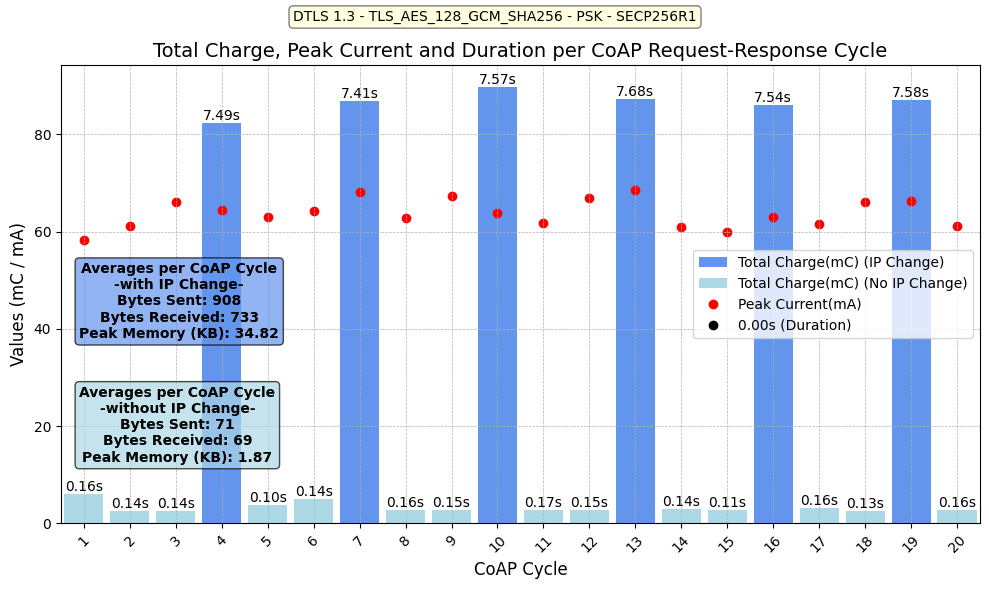

DTLS 1.3 - TLS_AES_128_GCM_SHA256 - PSK - SECP256R1


In [11]:
# Plot Total Charge (mC) and Peak Current (mA) for D0 groups
if "_noCID" in filename:
    print("noCID is in the filename")
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.xlim(current_coap.index[0] - 0.5, current_coap.index[-1] + 0.5)

    xlabel_text = f"CoAP Cycles : {dtls_version} - {cipher_suite} - {auth_method} - {curve}"
    special_indices = [4, 7, 10, 13, 16, 19]

    cornflowerblue_data = current_coap[current_coap.index.isin(special_indices)]
    lightblue_data = current_coap[~current_coap.index.isin(special_indices)]
    cornflowerblue_data["Peak Memory (KB)"] = cornflowerblue_data["Peak Memory(Bytes)"] / 1024
    lightblue_data["Peak Memory (KB)"] = lightblue_data["Peak Memory(Bytes)"] / 1024

    # Averages for each group
    cornflowerblue_avg = (
        f"Averages per CoAP Cycle\n"
        f"-with IP Change-\n"
        f"Bytes Sent: {int(cornflowerblue_data['Bytes_Sent'].mean())}\n"
        f"Bytes Received: {int(cornflowerblue_data['Bytes_Received'].mean())}\n"
        f"Peak Memory (KB): {cornflowerblue_data['Peak Memory (KB)'].mean():.2f}"
    )
    lightblue_avg = (
        f"Averages per CoAP Cycle\n"
        f"-without IP Change-\n"
        f"Bytes Sent: {int(lightblue_data['Bytes_Sent'].mean())}\n"
        f"Bytes Received: {int(lightblue_data['Bytes_Received'].mean())}\n"
        f"Peak Memory (KB): {lightblue_data['Peak Memory (KB)'].mean():.2f}"
    )

    bars_coap = plt.bar(
        current_coap.index, 
        current_coap["Total_Charge(mC)"], 
        color=["cornflowerblue" if idx in special_indices else "lightblue" for idx in current_coap.index],
        label="Total Charge (mC)",
        width=0.85,  # Reduce bar width 
    )

    legend_elements = [
        Patch(facecolor="cornflowerblue", edgecolor="none", label="Total Charge(mC) (IP Change)"),
        Patch(facecolor="lightblue", edgecolor="none", label="Total Charge(mC) (No IP Change)"),
        mlines.Line2D([], [], color="red", marker="o", linestyle="None", label="Peak Current(mA)"),
        mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="0.00s (Duration)")
    ]

    # Update the legend to include this distinction
    plt.legend(
        handles=legend_elements,
        fontsize=10,
        loc="center right",
        bbox_to_anchor=(1, 0.5)
    )

    plt.scatter(
        current_coap.index, 
        current_coap["Peak_Current"], 
        color="red", 
        marker="o", 
        label="Peak Current(mA)"
    )

    for bar, time_diff in zip(bars_coap, current_coap["Time_Diff(s)"]):  # Assuming 'Time_Diff(s)' exists
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
            bar.get_height(),               # Y-coordinate (above the bar)
            f"{time_diff:.2f}s",                 # Format duration as seconds
            ha="center",                        # Horizontal alignment
            va="bottom",                        # Vertical alignment
            fontsize=10,
            #bbox=dict(boxstyle="round,pad=0.1", edgecolor="darkgreen", facecolor="lightyellow")  # Highlighted text box
        )
        
    props = dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="gray")

    plt.text(
        0.02, 0.57,  # Position of the text box
        f"{cornflowerblue_avg}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        fontweight="bold",
        multialignment="center",
        bbox=dict(boxstyle="round", facecolor="cornflowerblue", alpha=0.7, edgecolor="black"),  # Box with cornflowerblue fill
        color="black",  # Text color contrasts with the box fill
    )

    plt.text(
        0.02, 0.3,  # Position of the text box
        f"{lightblue_avg}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        fontweight="bold",
        multialignment="center",
        bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7, edgecolor="black"),  # Box with cornflowerblue fill
        color="black",  # Text color contrasts with the box fill
    )
        
    cipher_info = f"{dtls_version} - {cipher_suite} - {auth_method} - {curve}"
    top_y = current_coap["Total_Charge(mC)"].max()  # Find the highest value in the bar data
    text_y = top_y + (0.1 * top_y)  # Add a margin above the highest bar

    plt.text(         
        0.5, 0.95,
        cipher_info,
        fontsize=10,
        ha="center",  # Align text to the right
        va="bottom", # Align text to the bottom
        transform=plt.gcf().transFigure,  # Use figure-relative positioning
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="lightyellow")
    )

    # Add labels, title, and legend for D0
    plt.xlabel("CoAP Cycle", fontsize=12)
    plt.ylabel("Values (mC / mA)", fontsize=12)
    plt.title("Total Charge, Peak Current and Duration per CoAP Request-Response Cycle", fontsize=14)

    # Customize grid and ticks
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(current_coap.index, rotation=45, fontsize=10)
    plt.tight_layout()

    plot_file = rf"{base_path}\python_adjusted\plots\coap_cycles\{filename}_cycles.png"
    #plt.savefig(plot_file)
    #print(f"Saved plot to {plot_file}")
    # Show the plot for D0
    plt.show()
    print(cipher_info)

Saved plot to C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen\python_adjusted\plots\handshakes\v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK_handshake.png


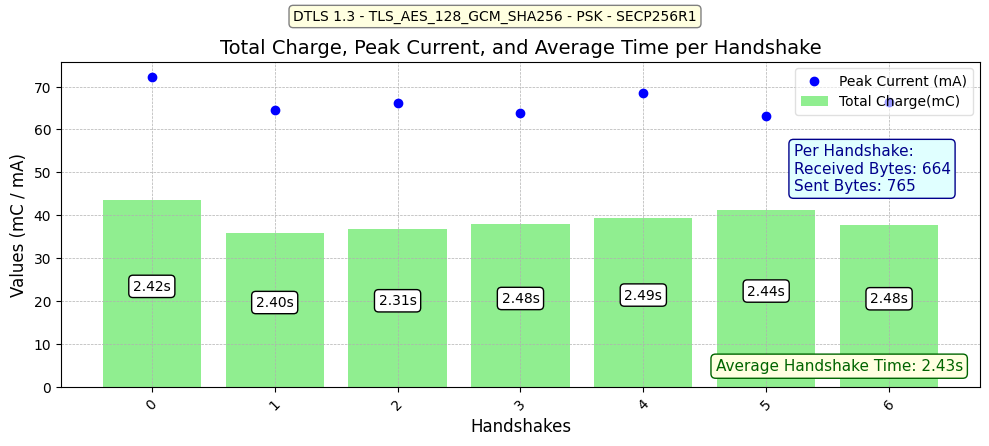

In [12]:
average_handshake_time = current_handshakes["Time_Diff(s)"].mean()
max_bar_height = current_handshakes["Total_Charge(mC)"].max()

# Plot Total Charge (mC) and Peak Current (mA) for D1 groups
plt.figure(figsize=(10, 4.5))  # Set figure size

# Assign the bar plot to a variable for accessing bar properties
bars_handshakes = plt.bar(
    current_handshakes.index, 
    current_handshakes["Total_Charge(mC)"], 
    color="lightgreen", 
    label="Total Charge(mC)"
)

plt.scatter(
    current_handshakes.index, 
    current_handshakes["Peak_Current"], 
    color="blue", 
    marker="o", 
    label="Peak Current (mA)", 
    zorder=3  # Ensure points are drawn above the bars
)

# Add time labels on top of the bars
for bar, time_diff in zip(bars_handshakes, current_handshakes["Time_Diff(s)"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() /2,            # Y-coordinate (above the bar)
        f"{time_diff:.2f}s",               # Format time as seconds
        ha="center",                       # Horizontal alignment
        va="bottom",                       # Vertical alignment
        fontsize=10,                       # Font size
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")  # Optional background
    )
    
# Display the overall average handshake time closer to the bar heights
plt.text(
    len(current_handshakes) - 0.4,  # X-coordinate near the rightmost bar
    3,             # Y-coordinate slightly above the tallest bar
    f"Average Handshake Time: {average_handshake_time:.2f}s",  # Text to display
    fontsize=11,
    color="darkgreen",
    ha="right",  # Align text to the right
    va="bottom", # Align text to the bottom of the text box
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="darkgreen", facecolor="lightyellow")  # Highlighted text box
)

average_received_bytes = current_handshakes["Bytes_Received"].mean()
average_sent_bytes = current_handshakes["Bytes_Sent"].mean()

# Display the per-handshake received and sent bytes
plt.text(
    len(current_handshakes) - 0.5,  # X-coordinate near the rightmost bar
    45,  # Y-coordinate slightly below the first box
    f"Per Handshake:\nReceived Bytes: {int(average_received_bytes)}\nSent Bytes: {int(average_sent_bytes)}",  # Format as integers
    fontsize=11,
    color="darkblue",
    ha="right",  # Align text to the right
    va="bottom",  # Align text to the bottom of the text box
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="darkblue", facecolor="lightcyan"),  # Highlighted text box
    multialignment="left"
)

plt.text(         
    0.5, 0.95,
    cipher_info,
    fontsize=10,
    ha="center",  # Align text to the right
    va="bottom", # Align text to the bottom
    transform=plt.gcf().transFigure,  # Use figure-relative positioning
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="lightyellow")
)

# Add labels, title, and legend
xlabel_text = rf"Handshakes : {dtls_version} - {cipher_suite} - {auth_method} - {curve}"
plt.xlabel("Handshakes", fontsize=12)
plt.ylabel("Values (mC / mA)", fontsize=12)
plt.title("Total Charge, Peak Current, and Average Time per Handshake", fontsize=14)
plt.legend(framealpha=0.6)

# Customize grid and ticks
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(current_handshakes.index, rotation=45, fontsize=10)
plt.tight_layout()
plot_file = rf"{base_path}\python_adjusted\plots\handshakes\{filename}_handshake.png"
plt.savefig(plot_file)
print(f"Saved plot to {plot_file}")

# Show the plot for D1
plt.show()

In [13]:
compare_results = pd.DataFrame(all_ciphers, columns=['ciphersuite'])

compare_results['wireshark time'] = None
compare_results['ppk time'] = None

In [14]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store results
result_df = pd.DataFrame(columns=['ciphersuite', 'wireshark_time', 'ppk_time'])

for filename in all_ciphers:
    # Read the CSV file for the current cipher
    data = pd.read_csv(rf"{base_path}\pcap\csv_exports\{filename}.csv")
    data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S,%f')

    # Initialize handshake durations and the alternation variable
    handshake_durations = []
    a = 1

    # Process each row in the DataFrame
    for i, row in data.iterrows():
        if "Client Hello" in row['Info'] and a == 1:
            client_hello_time = row['Time']
            a = 0
            # Find the second "Change Cipher Spec" after the current "Client Hello"
            change_cipher_spec_rows = data[
                (data['Info'].str.contains("Change Cipher Spec")) &
                (data.index > i)  # Only rows after this Client Hello
            ]
            if len(change_cipher_spec_rows) >= 2:
                second_change_cipher_spec_time = change_cipher_spec_rows.iloc[1]['Time']
                duration = (second_change_cipher_spec_time - client_hello_time).total_seconds()
                handshake_durations.append(duration)
        elif "Client Hello" in row['Info'] and a == 0:
            a = 1

    # Calculate the mean handshake duration for the current cipher
    mean_duration = np.mean(handshake_durations) if handshake_durations else 0

    # Add the ciphersuite and mean duration to the result DataFrame
    new_row = pd.DataFrame({
        'ciphersuite': [filename],
        'wireshark_time': [mean_duration],
        'ppk_time': [None]  # Placeholder for PPK time
    })

    # Use pd.concat to add the new row to result_df
    result_df = pd.concat([result_df, new_row], ignore_index=True)
print(result_df)

C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\3794722103.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, new_row], ignore_index=True)


                                         ciphersuite  wireshark_time ppk_time
0  v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...        6.947265     None
1   v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT        0.000000     None
2  v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...        5.881899     None
3      v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT        0.000000     None
4  v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_S...        2.134902     None
5    v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK        0.000000     None
6  v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_X...        1.165658     None
7       v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_PSK        0.000000     None


In [15]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store results
result_df = pd.DataFrame(columns=['ciphersuite', 'wireshark_time', 'ppk_time'])

for filename in all_ciphers:
    # Read the first CSV file (Wireshark data)
    data = pd.read_csv(rf"{base_path}\pcap\csv_exports\{filename}.csv")
    data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S,%f')

    # Initialize handshake durations
    handshake_durations = []

    # Check if the filename indicates DTLS 1.3
    if "v1_3" in filename:
        # For DTLS 1.3: Find first Client Hello and first 82-byte Encrypted Data
        client_hello_row = data[data['Info'].str.contains("Client Hello")].iloc[0]
        encrypted_data_rows = data[
            (data['Info'].str.contains("Encrypted Data")) & 
            (data['Length'] == 82)
        ]
        
        if not encrypted_data_rows.empty:
            client_hello_time = client_hello_row['Time']
            encrypted_data_time = encrypted_data_rows.iloc[0]['Time']
            duration = (encrypted_data_time - client_hello_time).total_seconds()
            handshake_durations.append(duration)
    
    else:
        # For DTLS 1.2: Original logic (Client Hello to second Change Cipher Spec)
        a = 1
        for i, row in data.iterrows():
            if "Client Hello" in row['Info'] and a == 1:
                client_hello_time = row['Time']
                a = 0
                # Find the second Change Cipher Spec after this Client Hello
                change_cipher_spec_rows = data[
                    (data['Info'].str.contains("Change Cipher Spec")) & 
                    (data.index > i)
                ]
                if len(change_cipher_spec_rows) >= 2:
                    second_change_cipher_spec_time = change_cipher_spec_rows.iloc[1]['Time']
                    duration = (second_change_cipher_spec_time - client_hello_time).total_seconds()
                    handshake_durations.append(duration)
            elif "Client Hello" in row['Info'] and a == 0:
                a = 1

    # Calculate the mean handshake duration
    mean_duration = np.mean(handshake_durations) if handshake_durations else 0

    # Read the second CSV file (PPK data)
    try:
        ppk_data = pd.read_csv(rf"{base_path}\python_adjusted\combined_data\handshakes\{filename}_handshakes.csv")
        if 'Time_Diff(s)' in ppk_data.columns:
            ppk_mean_duration = ppk_data['Time_Diff(s)'].mean()
        else:
            ppk_mean_duration = None  # Handle missing column
    except FileNotFoundError:
        print(f"PPK file not found for {filename}")
        ppk_mean_duration = None

    # Add the ciphersuite and calculated durations to the result DataFrame
    new_row = pd.DataFrame({
        'ciphersuite': [filename],
        'wireshark_time': [mean_duration],
        'ppk_time': [ppk_mean_duration]
    })

    # Use pd.concat to add the new row to result_df
    result_df = pd.concat([result_df, new_row], ignore_index=True)

C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1404990376.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, new_row], ignore_index=True)


In [16]:
result_df["wireshark_time"] = result_df["wireshark_time"] + 0.1
result_df["avg_curr_noIPchange"]=0
result_df["avg_curr_IPchange"]=0
result_df["peak_curr_noIPchange"]=0
result_df["peak_curr_IPchange"]=0
result_df["avg_total_charge_noIPchange"]=0
result_df["avg_total_charge_IPchange"]=0
result_df["avg_bytes_sent_IPchange"]=0
result_df["avg_bytes_sent_noIPchange"]=0
result_df["avg_bytes_received_IPchange"]=0
result_df["avg_bytes_received_noIPchange"]=0
result_df["peak_memory_IPchange"]=0
result_df["peak_memory_noIPchange"]=0
result_df["time_diff_IPchange"]=0
result_df["time_diff_noIPchange"]=0
result_df["handshake_size_sent"]=0
result_df["handshake_size_received"]=0
result_df["coap_cycle_timediff"]=0

result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_CID_SECP256R1_CERT', 'wireshark_time'] = 6.0
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_CID_X25519_CERT', 'wireshark_time'] = 6.1
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT', 'wireshark_time'] = 6.1
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT', 'wireshark_time'] = 6.0

result_df.loc[result_df['ciphersuite'] == 'v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID_SECP256R1_CERT', 'coap_cycle_timediff'] = 12.18
result_df.loc[result_df['ciphersuite'] == 'v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID_X25519_CERT', 'coap_cycle_timediff'] = 11.05
result_df.loc[result_df['ciphersuite'] == 'v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_SECP256R1_PSK', 'coap_cycle_timediff'] = 7.28
result_df.loc[result_df['ciphersuite'] == 'v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_X25519_PSK', 'coap_cycle_timediff'] = 6.48
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT', 'coap_cycle_timediff'] = 12.21
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT', 'coap_cycle_timediff'] = 12.16
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK', 'coap_cycle_timediff'] = 7.43
result_df.loc[result_df['ciphersuite'] == 'v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_PSK', 'coap_cycle_timediff'] = 7.34

C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\2313582021.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[result_df['ciphersuite'] == 'v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID_SECP256R1_CERT', 'coap_cycle_timediff'] = 12.18


In [17]:
for cipher in all_ciphers:
    filename = cipher
    file_path = rf"{base_path}\python_adjusted\combined_data\coap_cycles\{filename}_cycles.csv"
    df = pd.read_csv(file_path)
    file_path2 = rf"{base_path}\python_adjusted\combined_data\handshakes\{filename}_handshakes.csv"
    df2 = pd.read_csv(file_path2)
    #print(df.iloc[0, 0]) 
    # Define the special indices (1-based indexing, as in your file)
    special_indices = [4, 7, 10, 13, 16, 19]
    special_indices = [5, 8, 11, 14, 17, 20]
    special_indices_zero_based = [i - 2 for i in special_indices]  # Convert to 0-based indices
    other_rows = df.index.difference(special_indices_zero_based)  # Find indices not in special_indices

    # Calculate the average for rows in `special_indices`
    avg_current_IPchange = df.loc[special_indices_zero_based, "Avg_Current"].mean()
    # Calculate the average for all other rows
    avg_current_noIPchange=round(df.loc[other_rows, "Avg_Current"].mean(),2)
    avg_peak_IPchange = round(df.loc[special_indices_zero_based, "Peak_Current"].mean(),2)
    avg_peak_noIPchange = round(df.loc[other_rows, "Peak_Current"].mean(),2)
    avg_total_charge_IPchange = round(df.loc[special_indices_zero_based, "Total_Charge(mC)"].mean(),2)
    avg_total_charge_noIPchange = round(df.loc[other_rows, "Total_Charge(mC)"].mean(),2)
    avg_bytes_sent_IPchange = int(df.loc[special_indices_zero_based, "Bytes_Sent"].mean())
    avg_bytes_sent_noIPchange = int(df.loc[other_rows, "Bytes_Sent"].mean())
    avg_bytes_received_IPchange = int(df.loc[special_indices_zero_based, "Bytes_Received"].mean())
    avg_bytes_received_noIPchange = int(df.loc[other_rows, "Bytes_Received"].mean())
    peak_memory_IPchange = int(df.loc[special_indices_zero_based, "Peak Memory(Bytes)"].mean())
    peak_memory_noIPchange = int(df.loc[other_rows, "Peak Memory(Bytes)"].mean())
    avg_time_diff_IPchange = round(df.loc[special_indices_zero_based, "Time_Diff(s)"].mean(),2)
    avg_time_diff_noIPchange = round(df.loc[other_rows, "Time_Diff(s)"].mean(),2)
    handshake_size_sent = int(df2["Bytes_Sent"].mean())
    handshake_size_received = int(df2["Bytes_Received"].mean())
    #print(df)
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_curr_noIPchange'] = avg_current_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_curr_IPchange'] = avg_current_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'peak_curr_noIPchange'] = avg_peak_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'peak_curr_IPchange'] = avg_peak_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_total_charge_noIPchange'] = avg_total_charge_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_total_charge_IPchange'] = avg_total_charge_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_bytes_sent_IPchange'] = avg_bytes_sent_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_bytes_sent_noIPchange'] = avg_bytes_sent_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_bytes_received_IPchange'] = avg_bytes_received_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'avg_bytes_received_noIPchange'] = avg_bytes_received_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'peak_memory_IPchange'] = peak_memory_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'peak_memory_noIPchange'] = peak_memory_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'time_diff_IPchange'] = avg_time_diff_IPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'time_diff_noIPchange'] = avg_time_diff_noIPchange
    result_df.loc[result_df['ciphersuite'] == filename, 'handshake_size_sent'] = handshake_size_sent
    result_df.loc[result_df['ciphersuite'] == filename, 'handshake_size_received'] = handshake_size_received

result_df=round(result_df,2)
result_df
all_values = rf"{base_path}\allvalues.csv"
try:
    result_df.to_csv(all_values, index=False)
    print(f"File saved successfully at {all_values}")
except Exception as e:
    print(f"Error saving file: {e}")
result_df


C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1883486452.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.47' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[result_df['ciphersuite'] == filename, 'avg_curr_noIPchange'] = avg_current_noIPchange
C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1883486452.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.43' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[result_df['ciphersuite'] == filename, 'avg_curr_IPchange'] = avg_current_IPchange
C:\Users\jzurn\AppData\Local\Temp\ipykernel_16052\1883486452.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '62.56' has dtype inco

File saved successfully at C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen\allvalues.csv


,ciphersuite,wireshark_time,ppk_time,avg_curr_noIPchange,avg_curr_IPchange,peak_curr_noIPchange,peak_curr_IPchange,avg_total_charge_noIPchange,avg_total_charge_IPchange,avg_bytes_sent_IPchange,avg_bytes_sent_noIPchange,avg_bytes_received_IPchange,avg_bytes_received_noIPchange,peak_memory_IPchange,peak_memory_noIPchange,time_diff_IPchange,time_diff_noIPchange,handshake_size_sent,handshake_size_received,coap_cycle_timediff
0,v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...,7.05,7.09,22.47,11.43,62.56,66.92,3.25,139.86,1496,86,1454,84,37820,1916,12.24,0.15,1323,1371,12.18
1,v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT,6.10,7.14,26.60,11.00,60.67,66.59,3.08,134.95,1576,71,1661,69,36698,1916,12.26,0.12,1433,1592,12.21
2,v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...,5.98,5.99,26.08,11.40,68.26,73.23,3.36,127.17,1463,86,1421,84,35704,1916,11.16,0.14,1290,1337,11.05
3,v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT,6.00,7.14,20.63,11.46,61.53,66.97,2.99,141.22,1545,71,1636,69,36697,1916,12.32,0.15,1402,1567,12.16
4,v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_S...,2.23,2.29,22.98,11.38,62.71,66.38,3.31,84.71,722,86,668,84,33822,1916,7.44,0.14,549,584,7.28
5,v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK,1.45,2.43,22.72,11.48,62.96,65.73,3.18,86.60,908,71,733,69,35655,1916,7.54,0.14,765,664,7.43
6,v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_X...,1.27,1.31,22.24,11.35,64.24,74.54,3.25,73.63,689,86,635,84,6675,1916,6.49,0.15,516,551,6.48
7,v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_PSK,1.37,2.44,23.50,10.81,59.76,62.72,3.51,82.01,877,71,708,69,29555,1916,7.59,0.15,734,639,7.34


In [18]:
print(result_df)

result_df["ciphersuite"] = result_df["ciphersuite"].str.replace(
    r"(v1_\d)_.*?_noCID_", r"\1_", regex=True
)
result_df["ciphersuite"] = result_df["ciphersuite"].str.replace(r"v1_2_", "", regex=False)
result_df["ciphersuite"] = result_df["ciphersuite"].str.replace(r"v1_3_", "", regex=False)
#result_df["ciphersuite"] = result_df["ciphersuite"].str.lower()

print(result_df)
final_values = rf"{base_path}\finalvalues.csv"
result_df.to_csv(final_values, index=False)

                                         ciphersuite  wireshark_time  \
0  v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...            7.05   
1   v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_CERT            6.10   
2  v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256_noCID...            5.98   
3      v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_CERT            6.00   
4  v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_S...            2.23   
5    v1_3_TLS_AES_128_GCM_SHA256_noCID_SECP256R1_PSK            1.45   
6  v1_2_ECDHE_PSK_WITH_AES_128_GCM_SHA256_noCID_X...            1.27   
7       v1_3_TLS_AES_128_GCM_SHA256_noCID_X25519_PSK            1.37   

   ppk_time  avg_curr_noIPchange  avg_curr_IPchange  peak_curr_noIPchange  \
0      7.09                22.47              11.43                 62.56   
1      7.14                26.60              11.00                 60.67   
2      5.99                26.08              11.40                 68.26   
3      7.14                20.63           

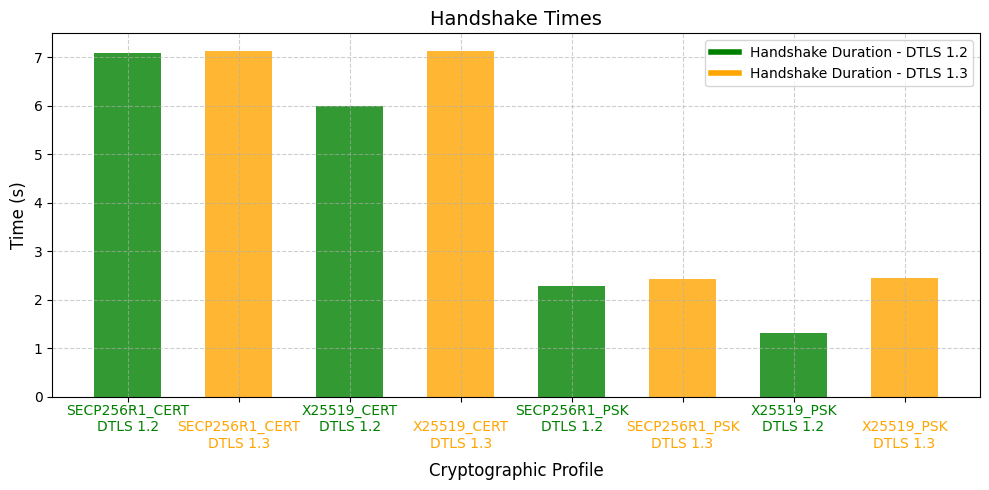

In [19]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))
short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]
colors = ["green", "orange"]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment

plt.bar(
    x_labels,  # X-axis labels
    result_df["ppk_time"],  # Y-axis values
    color=[colors[i % 2] for i in range(len(x_labels))],  # Alternate colors
    label="Duration of Completed Handshakes",
    width=0.6,  # Bar width
    alpha=0.8  # Transparency for better visualization
)

# Plot the data


# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Time (s)", fontsize=12)
ax.set_title("Handshake Times", fontsize=14)
custom_legend = [
    plt.Line2D([0], [0], color="green", lw=4, label="Handshake Duration - DTLS 1.2"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Handshake Duration - DTLS 1.3"),
]
ax.legend(handles=custom_legend, loc="upper right")
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\handshake_times.png"
plt.savefig(plot_file)
plt.show()

In [20]:
x_labels = np.arange(len(short_labels))
bar_width = 0.3

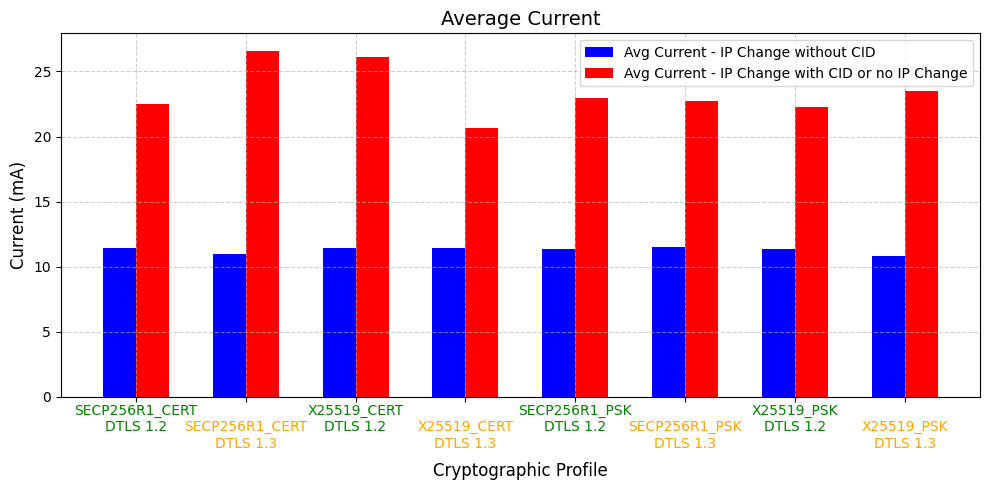

In [21]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))
short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = np.arange(len(short_labels))
bar_width = 0.3

bar2 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["avg_curr_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Avg Current - IP Change without CID"
)

bar1 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["avg_curr_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Avg Current - IP Change with CID or no IP Change"
)

# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    

# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Current (mA)", fontsize=12)
ax.set_title("Average Current", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\avg_current.png"
plt.savefig(plot_file)
plt.show()

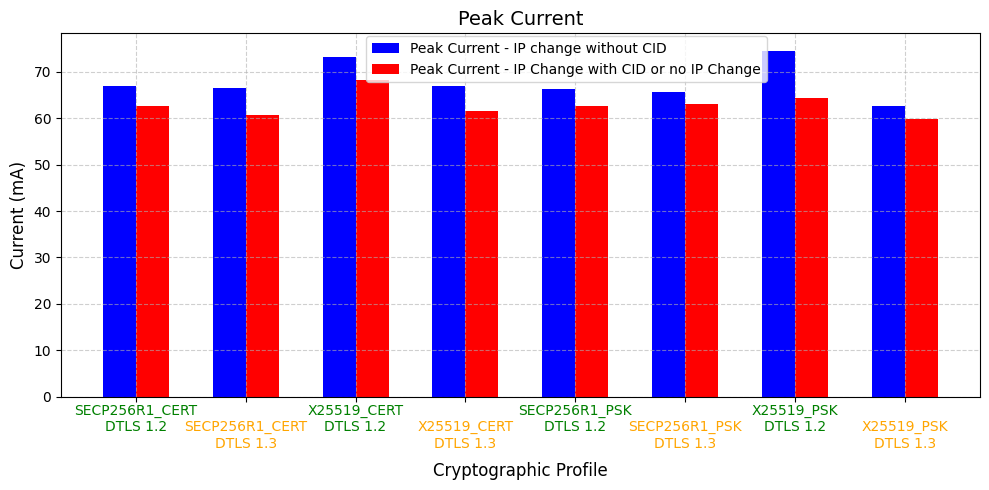

In [22]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment

x_labels = np.arange(len(short_labels))
bar_width = 0.3

bar1 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["peak_curr_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Peak Current - IP change without CID",
)

bar2 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["peak_curr_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Peak Current - IP Change with CID or no IP Change",
)

# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Current (mA)", fontsize=12)
ax.set_title("Peak Current", fontsize=14)
ax.legend(loc="center", bbox_to_anchor=(0.55, 0.929), fontsize=10, ncol=1, frameon=True)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\peak_current.png"
plt.savefig(plot_file)
plt.show()

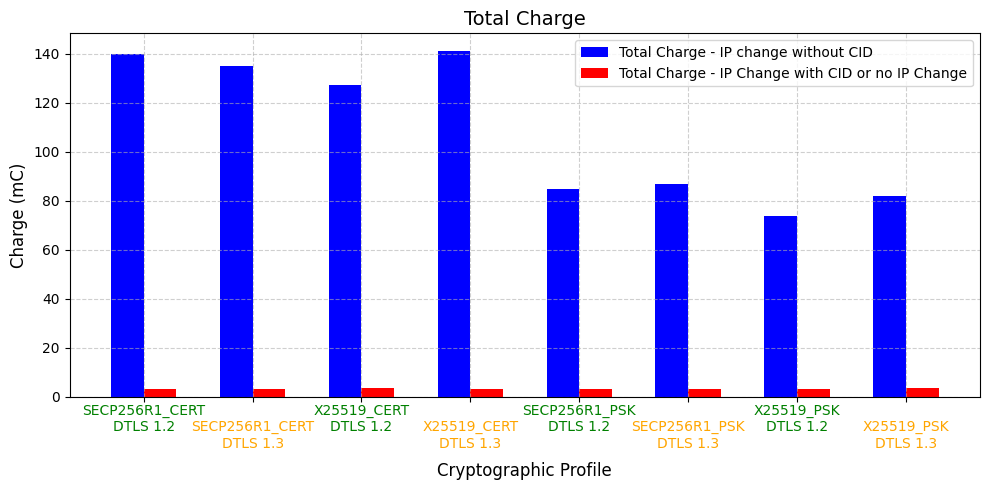

In [23]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = np.arange(len(short_labels))
bar_width = 0.3

# Plot the data
bar1 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["avg_total_charge_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Total Charge - IP change without CID",
)

bar2 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["avg_total_charge_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Total Charge - IP Change with CID or no IP Change",
)

# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Charge (mC)", fontsize=12)
ax.set_title("Total Charge", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\total_charge.png"
plt.savefig(plot_file)
plt.show()

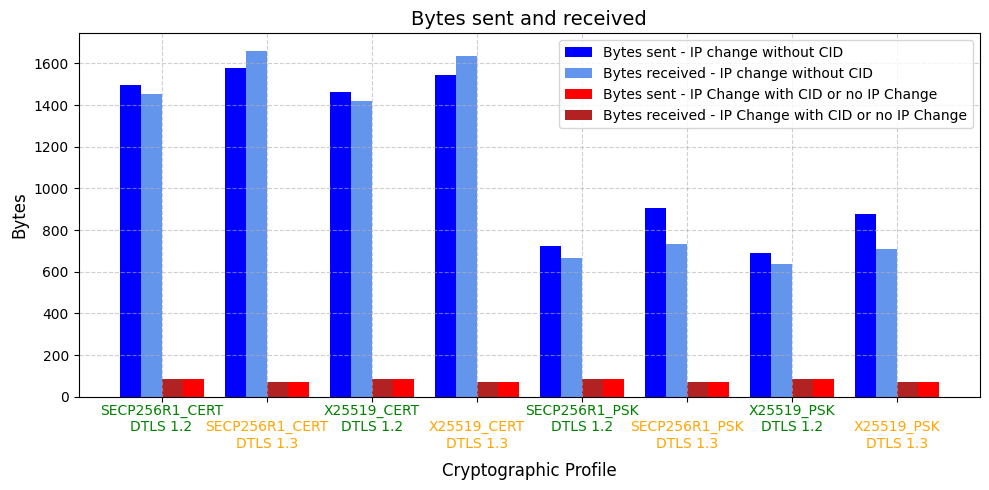

In [24]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = np.arange(len(short_labels))
bar_width = 0.2

# Plot the data
bar1 = ax.bar(
    x_labels - bar_width *1.5, 
    result_df["avg_bytes_sent_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Bytes sent - IP change without CID",
)

bar1 = ax.bar(
    x_labels - bar_width * 0.5, 
    result_df["avg_bytes_received_IPchange"], 
    width=bar_width, 
    color="cornflowerblue", 
    label="Bytes received - IP change without CID",
)

bar1 = ax.bar(
    x_labels + bar_width * 1.5, 
    result_df["avg_bytes_sent_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Bytes sent - IP Change with CID or no IP Change",
)

bar1 = ax.bar(
    x_labels + bar_width * 0.5, 
    result_df["avg_bytes_received_noIPchange"], 
    width=bar_width, 
    color="firebrick", 
    label="Bytes received - IP Change with CID or no IP Change",
)
# Plot the data


# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Bytes", fontsize=12)
ax.set_title("Bytes sent and received", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\bytes.png"
plt.savefig(plot_file)
plt.show()

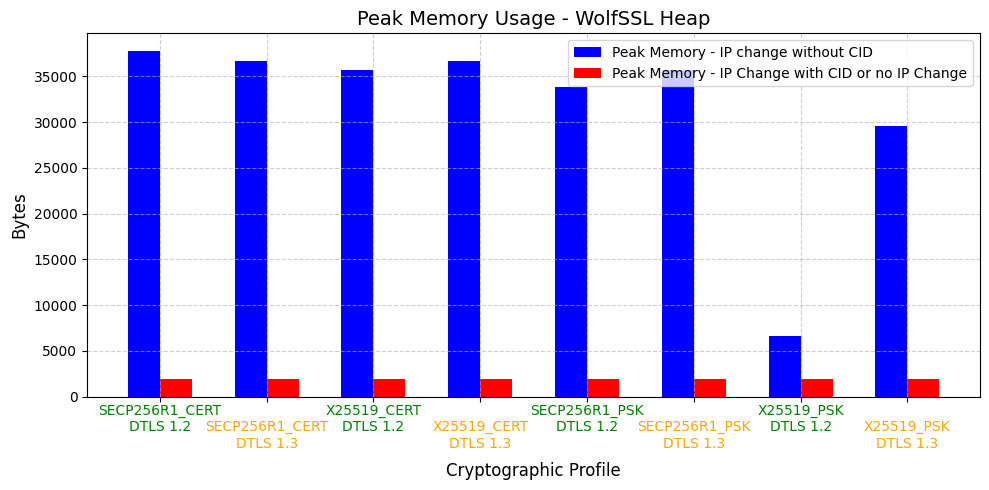

In [25]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = np.arange(len(short_labels))
bar_width = 0.3
# Plot the data


bar1 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["peak_memory_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Peak Memory - IP change without CID",
)

bar1 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["peak_memory_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Peak Memory - IP Change with CID or no IP Change",
)

# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Bytes", fontsize=12)
ax.set_title("Peak Memory Usage - WolfSSL Heap", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\memory.png"
plt.savefig(plot_file)
plt.show()

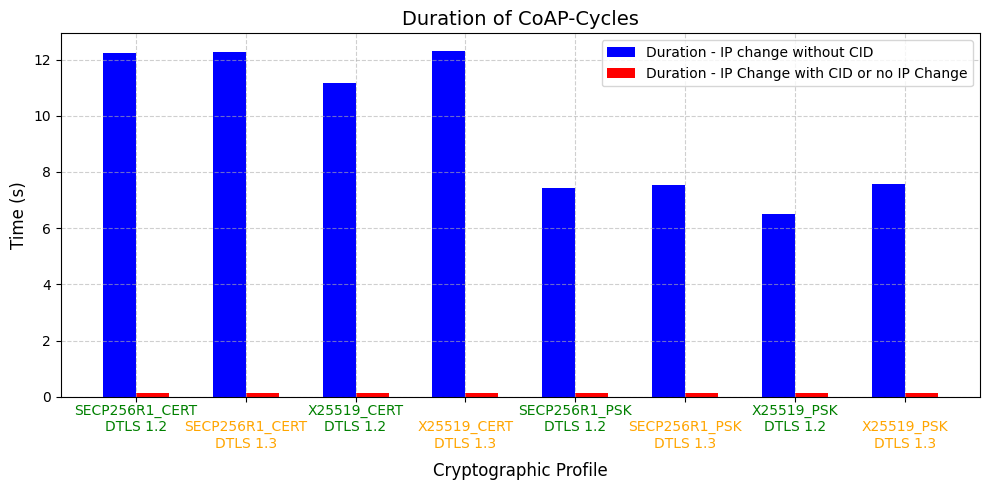

In [26]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = np.arange(len(short_labels))
bar_width = 0.3
# Plot the data


bar1 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["time_diff_IPchange"], 
    width=bar_width, 
    color="blue", 
    label="Duration - IP change without CID",
)

bar1 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["time_diff_noIPchange"], 
    width=bar_width, 
    color="red", 
    label="Duration - IP Change with CID or no IP Change",
)
# Plot the data


# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Time (s)", fontsize=12)
ax.set_title("Duration of CoAP-Cycles", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\duration.png"
plt.savefig(plot_file)
plt.show()

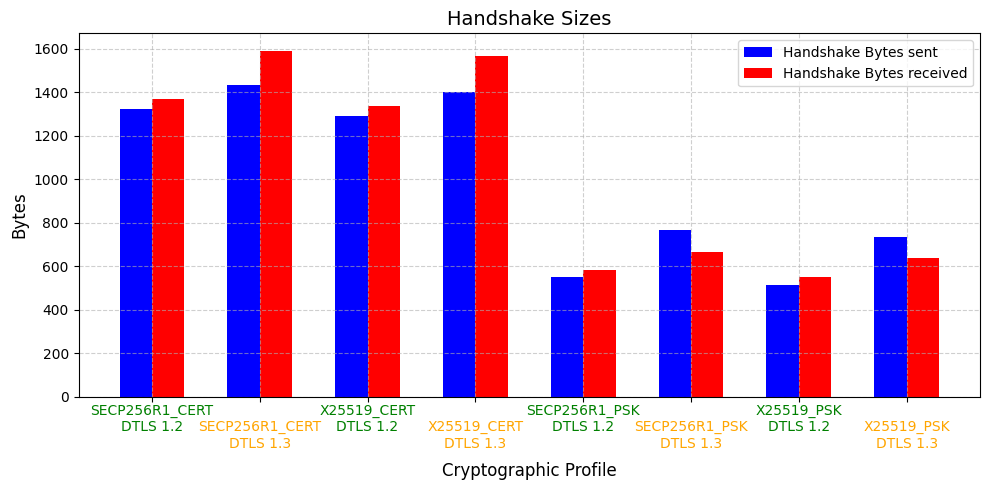

In [27]:
# Plot without index numbers, with adjusted x-labels and "Cipher Suite" positioned below
fig, ax = plt.subplots(figsize=(10, 5))

short_labels = [
    f"{label}\nDTLS 1.2\n" if i % 2 == 0 else f"\n{label}\nDTLS 1.3\n"
    for i, label in enumerate(result_df["ciphersuite"])
]
label_colors = ["green" if i % 2 == 0 else "orange" for i in range(len(short_labels))]

x_labels = range(len(short_labels))  # Numeric x-axis for alignment
x_labels = np.arange(len(short_labels))
bar_width = 0.3
# Plot the data


bar1 = ax.bar(
    x_labels - bar_width / 2, 
    result_df["handshake_size_sent"], 
    width=bar_width, 
    color="blue", 
    label="Handshake Bytes sent",
)

bar1 = ax.bar(
    x_labels + bar_width / 2, 
    result_df["handshake_size_received"], 
    width=bar_width, 
    color="red", 
    label="Handshake Bytes received",
)

# Set x-ticks and individually color the x-labels without showing numeric indices
ax.set_xticks(x_labels)
ax.set_xticklabels([])  # Remove numeric indices

# Manually add the custom-colored labels closer to the graph
for tick, label, color in zip(ax.get_xticks(), short_labels, label_colors):
    ax.text(
        tick, -0.02, label, fontsize=10, color=color, ha='center', va='top',
        transform=ax.get_xaxis_transform()
    )
    
# Adjust x-axis label placement
ax.set_xlabel("Cryptographic Profile", fontsize=12, labelpad=40)  # Adjust spacing with `labelpad`
ax.set_ylabel("Bytes", fontsize=12)
ax.set_title("Handshake Sizes", fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plot_file = rf"{base_path}\handshake_sizes.png"
plt.savefig(plot_file)
plt.show()